In [1]:
import pandas as pd
import sys
import numpy as np
import random
from fuzzywuzzy import fuzz
import time
import psycopg2
import warnings
from scourgify import normalize_address_record
import networkx as nx
import pickle


import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression , LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

C:\ProgramData\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:

_user = ***
_dbname = ***
_host = ***
_secret_key = ***
_db_connection = psycopg2.connect(user = _user, dbname = _dbname, host = _host, password = _secret_key,port = ***)


In [3]:

def query_to_pandas(query,conn):
    '''
    Function to turn a hive query into a pandas data DataFrame
    '''
    with conn.cursor() as cur:
        cur.execute(query)
        colnames = [desc[0] for desc in cur.description]
        val=cur.fetchall()
        df=pd.DataFrame(data=val,columns=colnames)
        return(df)

In [4]:
features = '''
rollback;
select * FROM datascience.final_without_bbf_onehot
'''

df1 = query_to_pandas(features, _db_connection
)

In [5]:
df1['has_made_cpe_in_lookahead'].value_counts()

0    315918
1      3348
Name: has_made_cpe_in_lookahead, dtype: int64

In [6]:
list(df1.columns)

['snapframe',
 'contact_id',
 'avg_days_btw_purchase',
 'days_since_last_order',
 'days_btw_reg_and_1storder',
 'created_date',
 'first_order_revenuee',
 'first_order_bill',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west',
 'last_order_revenue',
 'last_order_big4',
 'last_order_nonbig4',
 'last_order_university',
 'last_order_bill',
 'total_orders',
 'completed_orders',
 'cancelled_returned_orders',
 'direct_bill_orders',
 'nondirect_bill_orders',
 'is_cpa',
 'has_made_db_order',
 'has_made_nondb_order',
 'made_big4_order',
 'made_non_big4_order',
 'made_university_orders',
 'big4_orders',
 'non_big4_orders',
 'university_orders',
 'discount_percentage',
 'number_of_orders_p36m',
 'number_of_orders_p30m',
 'number_of_orders_p24m',
 'number_of_orders_p18m',
 'number_of_orders_p12m',
 'number_of_orders_p6m',
 'number_of_orders_p3m',
 'total_revenue_p36m',
 'total_revenue_p30m',
 'total_revenue_p24m',
 'total_revenue_p18m',
 'total_revenue_p12m',
 'total_revenue_p6m',


In [7]:
list(df1.columns)


df1=df1[['snapframe',
 'contact_id',
 'avg_days_btw_purchase',
 'days_since_last_order',
 'days_btw_reg_and_1storder',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west',
 'last_order_revenue',
 'last_order_big4',
 'last_order_nonbig4',
 'last_order_university',
 'last_order_bill',
  'is_cpa',
  'first_order_revenuee',
  'first_order_bill',
 'total_orders',
 'completed_orders',
 'cancelled_returned_orders',
 'direct_bill_orders',
 'nondirect_bill_orders',
 'has_made_db_order',
 'has_made_nondb_order',
 'made_big4_order',
 'made_non_big4_order',
 'made_university_orders',
 'big4_orders',
 'non_big4_orders',
 'university_orders',
 'discount_percentage',
  'number_of_orders_p36m',
  'number_of_orders_p30m',
 'number_of_orders_p24m',
 'number_of_orders_p18m',
 'number_of_orders_p12m',
 'number_of_orders_p6m',
 'number_of_orders_p3m',
 'total_revenue_p18m',
  'total_revenue_p24m',
  'total_revenue_p30m',
   'total_revenue_p36m',
 'total_revenue_p12m',
 'total_revenue_p6m',
 'total_revenue_p3m',
 'total_discount_p18m',
 'total_discount_p24m',
 'total_discount_p30m',
 'total_discount_p36m',
  'total_discount_p12m',
  'total_discount_p6m',
 'courses_completed_p3m',
 'courses_completed_p6m',
 'courses_completed_p12m',
  'courses_completed_p24m',
  'courses_completed_p36m',
 'has_completed_course_p3m',
 'has_completed_course_p6m',
 'has_completed_course_p12m',
 'tenure_1st_order',
 'has_bought_exam_review',
 'has_bought_mcq',
 'has_bought_flashcards',
 'has_bought_textbook',
 'has_bought_final_review',
 'lsto_has_bought_exam_review',
 'lsto_has_bought_mcq',
 'lsto_has_bought_flashcards',
 'lsto_has_bought_textbook',
 'lsto_has_bought_final_review',
  'has_made_cpe_in_lookahead']]

In [8]:
df1_contact = df1[['snapframe','contact_id']]
df1_data = df1.loc[:,['avg_days_btw_purchase','days_btw_reg_and_1storder',
 'days_since_last_order',
 'state_northeast',
 'state_midwest',
 'state_south',
 'state_west',
 'last_order_revenue',
 'last_order_bill',
 'total_orders',
 'completed_orders',
 'cancelled_returned_orders',
  'is_cpa',
  'first_order_revenuee',
  'first_order_bill',
 'has_made_db_order',
 'has_made_nondb_order',
 'made_big4_order',
 'made_non_big4_order',
 'made_university_orders',
 'discount_percentage',
 'number_of_orders_p24m',
  'number_of_orders_p30m',
  'number_of_orders_p36m',
 'number_of_orders_p18m',
 'number_of_orders_p12m',
 'number_of_orders_p6m',
 'number_of_orders_p3m',
 'total_revenue_p18m',
'total_revenue_p24m',
 'total_revenue_p30m',
 'total_revenue_p36m',
 'total_revenue_p12m',
 'total_revenue_p6m',
 'total_revenue_p3m',
 'total_discount_p18m',
  'total_discount_p12m',
  'total_discount_p6m',
 'courses_completed_p3m',
  'total_discount_p24m',
  'total_discount_p30m',
 'total_discount_p36m',
 'tenure_1st_order',
   'courses_completed_p24m',
   'courses_completed_p36m',
   'courses_completed_p6m',
   'courses_completed_p12m',
 'has_bought_exam_review',
 'has_bought_flashcards',
 'has_bought_textbook',
 'has_bought_final_review',
 'lsto_has_bought_exam_review',
 'lsto_has_bought_mcq',
 'lsto_has_bought_flashcards',
 'lsto_has_bought_textbook',
 'lsto_has_bought_final_review',
 'has_made_cpe_in_lookahead']]
    

In [9]:
rename_dict = {
  'days_btw_reg_and_1storder':'days_btw_registration_and_1storder',
  "last_order_bill": "last_order_direct_non-direct_bill_type", 
  'has_made_db_order':'has_made_direct_bill_order',
  "has_made_nondb_order": "has_made_non-direct_bill_order",
  "tenure_1st_order": 'tenure_from_1st_order-last_order',
  "lsto_has_bought_exam_review": 'has_bought_exam_review_in_last_order',
  'lsto_has_bought_mcq':'has_bought_mcq_in_last_order',
  "lsto_has_bought_flashcards":"has_bought_flashcards_in_last_order",
  "lsto_has_bought_final_review" : "has_bought_final_review_in_last_order",
  "lsto_has_bought_textbook" : "has_bought_textbook_in_last_order",
  'number_of_orders_p24m' : 'number_of_orders_past_24months',
 'number_of_orders_p18m' : "number_of_orders_past_18months",
 'number_of_orders_p12m' : "number_of_orders_past_12months",
 'number_of_orders_p6m' : "number_of_orders_past_6months",
 'number_of_orders_p3m' : "number_of_orders_past_3months",
    'total_revenue_p36m' : "total_revenue_past_36months",
 'total_revenue_p30m' : "total_revenue_past_30months",
 'total_revenue_p24m' : "total_revenue_past_24months",
 'total_revenue_p18m' : "total_revenue_past_18months",
 'total_revenue_p12m' : "total_revenue_past_12months",
 'total_revenue_p6m' : "total_revenue_past_6months",
 'total_revenue_p3m' : "total_revenue_past_3months",
 'total_discount_p18m' : "total_discount_past_18months",
    'total_discount_p12m' : "total_discount_past_12months",
    'total_discount_p24m' : "total_discount_past_24months",
    'total_discount_p36m' : "total_discount_past_36months",
    'total_discount_p6m' : "total_discount_past_6months",
    'total_discount_p30m' : "total_discount_past_30months",
 'courses_completed_p3m' : "exams_passed_past_3months",
    'courses_completed_p6m' : "exams_passed_past_6months",
    'courses_completed_p12m' : "exams_passed_past_12months",
    'courses_completed_p24m' : "exams_passed_past_24months",
    'courses_completed_p36m' : "exams_passed_past_36months",'first_order_revenuee' : 'first_order_revenue'
}

df1_data = df1_data.rename(columns=rename_dict)   

In [12]:
from sklearn.preprocessing import StandardScaler
features = ['total_revenue_past_12months' , 
            'total_revenue_past_18months' , 
            'total_revenue_past_24months' , 
           'total_revenue_past_30months' ,
           'total_revenue_past_36months' ,
            'total_revenue_past_6months',            
            'total_revenue_past_3months',   
            'total_discount_past_18months',
           'total_discount_past_12months',
           'total_discount_past_24months',
           'total_discount_past_30months',
            'total_discount_past_36months',
            'total_discount_past_6months',
           'last_order_revenue',
            'first_order_revenue']
for i in features:
    df1_data[i] = StandardScaler().fit_transform(df1_data[[i]])

,avg_days_btw_purchase,days_btw_registration_and_1storder,days_since_last_order,state_northeast,state_midwest,state_south,state_west,last_order_revenue,last_order_direct_non-direct_bill_type,total_orders,...,has_bought_exam_review,has_bought_flashcards,has_bought_textbook,has_bought_final_review,has_bought_exam_review_in_last_order,has_bought_mcq_in_last_order,has_bought_flashcards_in_last_order,has_bought_textbook_in_last_order,has_bought_final_review_in_last_order,has_made_cpe_in_lookahead
0,101,9,436,0,0,0,0,0.769256,1.0,1,...,1,1,0,0,1,0,1,0,0,0
1,101,4,599,0,0,0,0,0.545392,1.0,1,...,1,0,0,1,1,0,0,0,1,0
2,74,9,81,0,0,0,0,-0.912804,0.0,3,...,0,0,0,0,0,0,0,0,0,0
3,101,9,534,0,0,0,0,2.105472,0.0,1,...,1,0,0,0,1,0,0,0,0,0
4,28,9,144,0,0,0,0,-0.912804,0.0,2,...,1,0,0,0,0,0,0,0,0,0


In [13]:
#divide train and test (initially for building the model)
X_train, X_test, y_train, y_test = train_test_split(df1_data.drop('has_made_cpe_in_lookahead',axis=1), 
           df1_data['has_made_cpe_in_lookahead'], test_size=0.30, 
            random_state=102)

In [14]:
#dividing positive and negative cases
train = pd.concat([X_train,y_train],axis=1)
train_pos = train[train['has_made_cpe_in_lookahead'] == 1]
train_neg = train[train['has_made_cpe_in_lookahead'] == 0]

In [15]:
y_train

242848    0
7700      0
99062     0
72966     0
187510    0
         ..
17353     0
69611     0
117570    0
111471    0
108800    0
Name: has_made_cpe_in_lookahead, Length: 223486, dtype: int64

In [17]:
X_train

,avg_days_btw_purchase,days_btw_registration_and_1storder,days_since_last_order,state_northeast,state_midwest,state_south,state_west,last_order_revenue,last_order_direct_non-direct_bill_type,total_orders,...,exams_passed_past_12months,has_bought_exam_review,has_bought_flashcards,has_bought_textbook,has_bought_final_review,has_bought_exam_review_in_last_order,has_bought_mcq_in_last_order,has_bought_flashcards_in_last_order,has_bought_textbook_in_last_order,has_bought_final_review_in_last_order
242848,12,8,130,1,0,0,0,0.942621,1.0,3,...,0,1,0,1,0,1,0,0,1,0
7700,2,9,666,0,0,0,0,-0.912804,1.0,2,...,0,1,1,0,0,0,0,1,0,0
99062,111,9,635,0,0,0,0,-0.912804,0.0,1,...,0,0,0,0,0,0,0,0,0,0
72966,101,9,690,0,0,0,0,-0.912804,0.0,1,...,0,0,0,0,0,0,0,0,0,0
187510,111,9,311,0,0,1,0,1.108236,0.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17353,58,9,515,0,0,0,0,-0.678109,1.0,2,...,0,1,0,0,0,1,0,0,0,0
69611,105,9,410,0,0,0,0,0.703497,1.0,1,...,0,1,0,0,0,1,0,0,0,0
117570,226,1,193,1,0,0,0,-0.411972,1.0,5,...,0,1,1,1,0,1,0,0,1,0
111471,105,9,660,0,0,0,0,-0.912804,0.0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
len(train_pos)

2366

In [19]:
from xgboost import XGBClassifier
models = []
for i in range(0,15):
    train_sample = pd.concat([train_pos.sample(2000),train_neg.sample(8000)],axis=0)
    train_X = train_sample.iloc[:,0:56]
    train_Y = train_sample.iloc[:,-1]
# fit model no training data
    gmb = XGBClassifier(learning_rate =0.05, n_estimators=250, max_depth=6,
 min_child_weight=1, gamma=0.8, subsample=1, colsample_bytree=1,
 objective= 'binay:logistic', nthread=4, scale_pos_weight=4, seed=27)
    gmb.fit(train_X, train_Y)
    models += [gmb]
    # save the model to disk
    pickle.dump(models[i],open('gmb_i56_'+str(i)+'.sav','wb'))


In [38]:
from xgboost import XGBClassifier
models = []
for i in range(0,15):
    train_sample = pd.concat([train_pos.sample(2000),train_neg.sample(8000)],axis=0)
    train_X = train_sample.iloc[:,0:56]
    train_Y = train_sample.iloc[:,-1]
# fit model no training data
    gmb = XGBClassifier(learning_rate =0.07, n_estimators=250, max_depth=6,
 min_child_weight=1, gamma=0.8, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27)
    gmb.fit(train_X, train_Y)
    models += [gmb]
    # save the model to disk
    pickle.dump(models[i],open('gmb_i56_'+str(i)+'.sav','wb'))


In [39]:
#for testing
models1 = []
pred1 = pd.DataFrame()
for i in range(0,15):
    loaded_model = pickle.load(open('gmb_i56_'+str(i)+'.sav', 'rb'))
    models1 += [loaded_model]
    y_pred = models1[i].predict_proba(X_test)[:,1]
    pred1 = pd.concat([pred1, pd.DataFrame(y_pred, columns=[i])], axis =1)

In [40]:
#averege of probab for test
pred1['avg'] = pred1.mean(axis=1)
pred1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,avg
0,0.344047,0.327865,0.270568,0.360590,0.397012,0.282523,0.370463,0.261437,0.329771,0.354185,0.303129,0.354164,0.289042,0.274216,0.281311,0.320022
1,0.320140,0.463567,0.119212,0.530283,0.232675,0.443847,0.247162,0.371129,0.179161,0.238141,0.376357,0.243183,0.314664,0.304961,0.220334,0.306988
2,0.286625,0.183026,0.109223,0.280541,0.215376,0.209071,0.153630,0.157337,0.132948,0.220749,0.275418,0.263846,0.170609,0.275141,0.296144,0.215312
3,0.293131,0.262216,0.270050,0.214068,0.216584,0.172603,0.241023,0.254045,0.168561,0.274626,0.278975,0.244309,0.138936,0.248916,0.235731,0.234252
4,0.352120,0.306623,0.418983,0.357947,0.241207,0.347288,0.283754,0.332172,0.315509,0.361640,0.333454,0.259730,0.376322,0.265145,0.270832,0.321515


In [41]:
## Predictions and Accuracy

In [42]:
y_predictions=[1 if i > 0.50 else 0 for i in pred1['avg']]

In [43]:
accuracy = accuracy_score(y_test,y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.76%


In [44]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# confusion matrix
matrix = confusion_matrix(y_test,y_predictions, labels=[1,0])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[  615   367]
 [15187 79611]]


In [45]:

precision = precision_score(y_test,y_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test,y_predictions )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)


Precision: 0.038919
Recall: 0.626273


In [46]:
roc_auc_score(y_test,pred1['avg'])

0.8206975221705202

In [ ]:
###Shapley Values

In [47]:
pred2 = pd.concat([y_test.reset_index()['has_made_cpe_in_lookahead'],pred1['avg']], axis =1)
pred2.sort_values('avg',inplace = True)
import numpy as np
my_frames = np.array_split(pred2, 10)

decile_df = pd.DataFrame(columns = ["total","bucket","is_cpe","is_not_cpe","hit_rate"])
for i in range(0,10):
    frame = my_frames[i]
    bucket = str(frame['avg'].min())+'-'+str(frame['avg'].max())
    total = len(frame)
    is_cpe = frame['has_made_cpe_in_lookahead'].sum()
    is_not_cpe = total - is_cpe
    hitrate = is_cpe / is_not_cpe
    bucket = str(round(frame['avg'].min(),4))+'-'+str(round(frame['avg'].max(),4))
    metrice = [total,bucket,is_cpe,is_not_cpe,hitrate]
    a_series = pd.Series(metrice, index = decile_df.columns)
    decile_df = decile_df.append(a_series, ignore_index=True)
decile_df    

,total,bucket,is_cpe,is_not_cpe,hit_rate
0,9578,0.0097-0.1233,6,9572,0.000627
1,9578,0.1233-0.1703,17,9561,0.001778
2,9578,0.1704-0.2074,19,9559,0.001988
3,9578,0.2074-0.2439,31,9547,0.003247
4,9578,0.2439-0.2843,33,9545,0.003457
5,9578,0.2843-0.3257,41,9537,0.004299
6,9578,0.3257-0.3794,62,9516,0.006515
7,9578,0.3794-0.4622,105,9473,0.011084
8,9578,0.4622-0.5797,174,9404,0.018503
9,9578,0.5797-0.9783,494,9084,0.054381


In [36]:
decile_df.to_csv('decile_model2_1.csv')

In [36]:
def bucket(x):
    for i in np.arange(0,1.1,0.1):
        t = i +0.1
        if x > i and x <= t:
            return str(round(i,2)) +'-'+ str(round(t,2))

In [37]:
pred2['bucket'] = pred2['avg'].apply(lambda x:bucket(x))

In [38]:
pred2.to_csv('probability_wob_df.csv')

In [52]:
#Gamma Tuning

In [55]:


gamma = [i/10.0 for i in range(5,10)]

for gam in gamma:
    gb = XGBClassifier( learning_rate =0.06, n_estimators=250, max_depth=6,
 min_child_weight=1, gamma= gam, subsample=1, colsample_bytree=1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=4, seed=27 )
    gb.fit(train_X, train_Y)
    train_predprob = gb.predict_proba(train_X)[:,1]
    test_predprob = gb.predict_proba(X_test)[:,1]
    test_valid = [1 if i > 0.50 else 0 for i in test_predprob]

    print("reg alpha: ", gam)
    print("Accuracy score (test): {0:.3f}".format(roc_auc_score(y_test, test_predprob)))
    print("Accuracy score (train): {0:.3f}".format(roc_auc_score(train_Y, train_predprob)))
    print(classification_report(y_test,test_valid))
    

    

reg alpha:  0.5
Accuracy score (test): 0.789
Accuracy score (train): 0.941
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     94798
           1       0.03      0.61      0.06       982

    accuracy                           0.82     95780
   macro avg       0.51      0.71      0.48     95780
weighted avg       0.99      0.82      0.89     95780

reg alpha:  0.6
Accuracy score (test): 0.790
Accuracy score (train): 0.940
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     94798
           1       0.03      0.60      0.06       982

    accuracy                           0.81     95780
   macro avg       0.51      0.71      0.48     95780
weighted avg       0.99      0.81      0.89     95780

reg alpha:  0.7
Accuracy score (test): 0.790
Accuracy score (train): 0.939
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     94798
           1

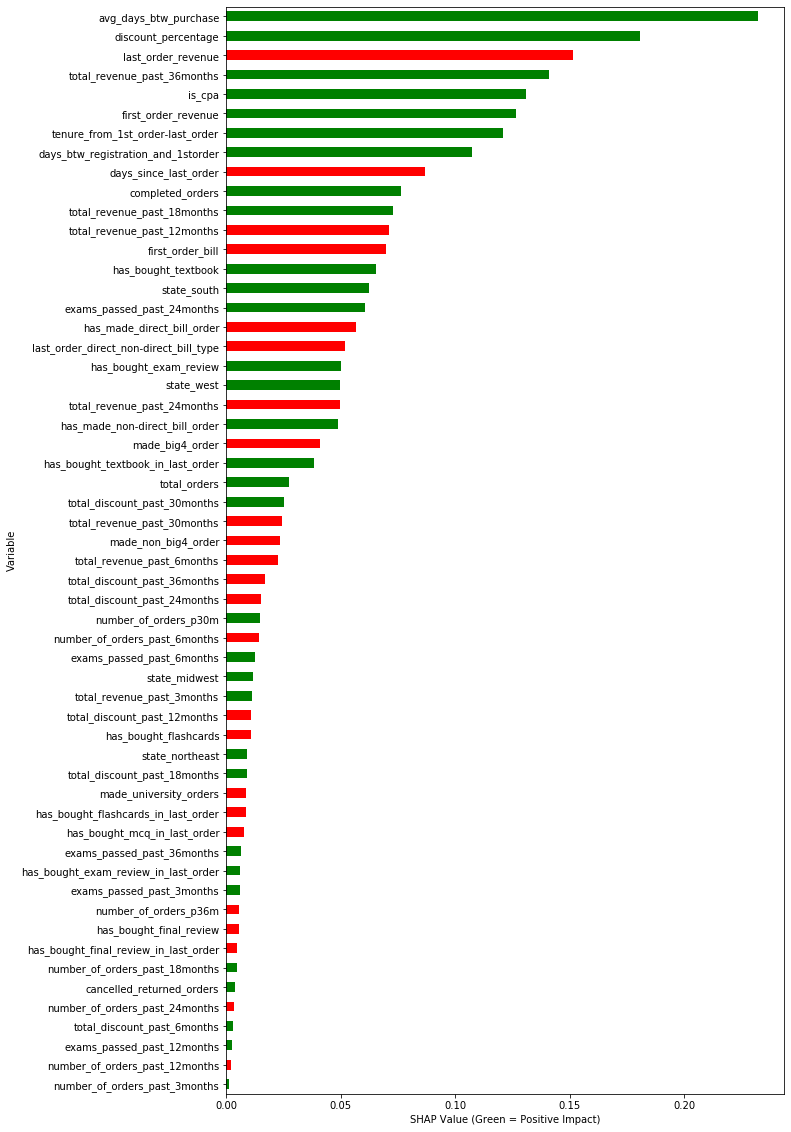

In [54]:
import shap
shap_values = shap.TreeExplainer(models1[3]).shap_values(X_test)

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'green','red')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,20),legend=False)
    ax.set_xlabel("SHAP Value (Green = Positive Impact)")
    
ABS_SHAP(shap_values,X_test)

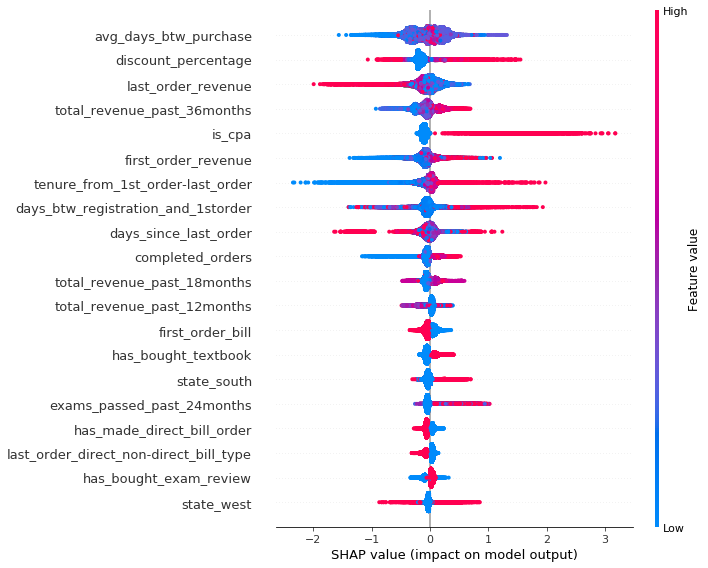

In [50]:
import shap
shap_values = shap.TreeExplainer(models1[3]).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

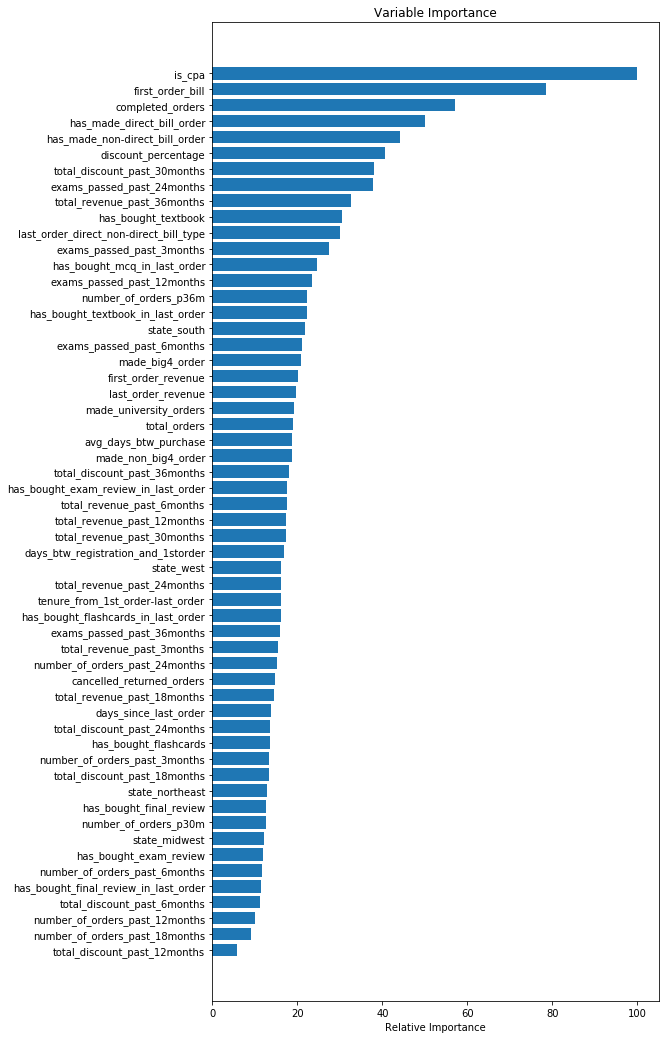

In [51]:
feature_importance = models[0].feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_X.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
#Shapley Modelling Examples(High , Medium and Low performing) 

In [39]:
shap_df = pd.DataFrame(shap_values[:,:], columns = X_test.columns, index = X_test.index)
shap_df.round(2)
pred3 = pd.concat([y_test.reset_index(),pred1['avg']], axis =1).set_index('index')
pred3.sort_values('avg',inplace = True)
my_frames = np.array_split(pred3, 10)

In [58]:
shap_dec = pd.merge(shap_df, my_frames[8], left_index=True, right_index=True)

In [59]:
shap_dec

,avg_days_btw_purchase,days_btw_registration_and_1storder,days_since_last_order,state_northeast,state_midwest,state_south,state_west,last_order_revenue,last_order_direct_non-direct_bill_type,total_orders,...,has_bought_flashcards,has_bought_textbook,has_bought_final_review,has_bought_exam_review_in_last_order,has_bought_mcq_in_last_order,has_bought_flashcards_in_last_order,has_bought_textbook_in_last_order,has_bought_final_review_in_last_order,has_made_cpe_in_lookahead,avg
195594,0.150080,-0.013338,-0.041136,0.000869,-0.005538,0.304933,-0.019149,0.129864,0.035957,0.208463,...,0.001914,-0.085919,-0.002916,-0.009161,0.004977,-0.027138,-0.005319,-0.002588,0,0.570370
128233,0.143544,-0.072496,0.081914,0.014956,0.000166,-0.014802,0.006903,0.075881,0.077294,-0.104027,...,-0.000175,-0.049455,-0.001451,-0.015348,0.002387,-0.042318,-0.021795,-0.000087,0,0.490910
300092,-0.357509,-0.052398,0.130794,-0.001500,-0.005444,-0.023461,0.264172,0.098260,-0.208914,-0.056853,...,0.020749,0.384285,-0.010573,0.038725,0.003254,-0.017675,0.007013,0.001032,0,0.486354
1053,-0.029219,-0.093514,-0.164332,0.006007,-0.000457,-0.054361,-0.022778,0.195494,0.052203,0.051573,...,-0.002154,-0.064750,-0.004036,-0.010448,-0.004173,-0.099797,-0.023592,-0.000130,0,0.510489
165099,0.042581,-0.077160,-0.020506,0.014257,-0.012509,-0.025841,-0.008692,0.172233,0.083475,-0.074972,...,-0.000043,-0.066141,0.000804,-0.011648,-0.005783,-0.086711,-0.022057,0.000106,0,0.582680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29540,-0.210336,-0.088178,0.028312,-0.002540,-0.020173,-0.053254,-0.011261,0.159347,0.056065,-0.058635,...,-0.004035,-0.059981,-0.000929,-0.023036,-0.005225,-0.059048,-0.032996,-0.000819,0,0.549538
213130,0.202679,-0.021352,0.021172,-0.000116,0.006918,-0.017605,0.179577,0.021660,0.062653,0.234863,...,-0.000466,0.111143,-0.016189,-0.019659,0.006838,-0.030780,0.006188,0.001385,0,0.503986
170447,0.210782,-0.103836,-0.024324,0.003149,-0.006681,-0.048822,-0.009221,-0.356619,0.078777,-0.062632,...,-0.004143,-0.065397,-0.000663,0.042857,-0.006081,-0.018216,-0.097521,-0.000772,0,0.481808
242083,-0.131487,0.114430,-0.008694,0.003710,0.025491,-0.019338,0.006293,-0.222171,0.104611,-0.041318,...,-0.007150,0.112210,-0.044145,0.011478,-0.001049,0.032184,0.140107,-0.009695,0,0.491629


In [60]:
shap_dec.to_csv("Model_2_shap_medium_performance_update.csv")

In [43]:
shap_df.mean(axis = 0).to_csv("avg_shap_model2_update.csv")

In [44]:
len(X_train),len(X_test),len(X_train)/len(X_test)

(223486, 95780, 2.3333263729379827)

In [65]:
df1.loc[148879]

snapframe                            2019-07-01
contact_id                      0030Z00003BkBi7
avg_days_btw_purchase                       134
days_since_last_order                       766
days_btw_reg_and_1storder                     2
                                     ...       
lsto_has_bought_mcq                           0
lsto_has_bought_flashcards                    0
lsto_has_bought_textbook                      0
lsto_has_bought_final_review                  0
has_made_cpe_in_lookahead                     0
Name: 236415, Length: 71, dtype: object

In [66]:
df1_contact.loc[148879]


snapframe          2018-07-01
contact_id    0030Z00003IDGH4
Name: 148879, dtype: object

In [67]:
df1_contact.loc[236415]

snapframe          2019-07-01
contact_id    0030Z00003BkBi7
Name: 236415, dtype: object